## 0. Introduction

The aim of this lab is to get familiar with **regression problems**, the concepts of **under/over-fitting**, and **regularization**.


1.   This lab is the first course-work activity **Assignment 1 part 1: Regression (10%)**
2. The Assignment is due on **Friday, 27th October, 11:59pm**
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!).


For this lab we will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset.

In [1]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

In [2]:
diabetes_db = pd.read_csv(
    'https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt',
    sep='\t', header=0)
sn.pairplot(diabetes_db)

Output hidden; open in https://colab.research.google.com to view.

In [3]:
diabetes_db.head(10)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.00,4.2905,80,135
5,23,1,22.6,89.0,139,64.8,61.0,2.00,4.1897,68,97
6,36,2,22.0,90.0,160,99.6,50.0,3.00,3.9512,82,138
7,66,2,26.2,114.0,255,185.0,56.0,4.55,4.2485,92,63
8,60,2,32.1,83.0,179,119.4,42.0,4.00,4.4773,94,110
9,29,1,30.0,85.0,180,93.4,43.0,4.00,5.3845,88,310


We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [4]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42)

x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(Y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(Y_test.values).float()
y_test = y_test.reshape(-1, 1)

We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [5]:
"""
PROGRAMMING NOTE:
In the below function definition, we are enforcing the datatypes for the
function's parameters & return value. For the argument parameters, we enforce
type for each argument as:

```
argName: argType
```

For return value, we enforce type as:

```
-> returnType
```
"""

def norm_set(x:torch.Tensor,mu:torch.Tensor,sigma:torch.Tensor)->torch.tensor:
  return torch.div(torch.sub(x, mu), sigma)

**SHAPE OF THE TENSOR & WHAT IT MEANS TO NORMALIZE**:<br>When we convert a dataset (with each columns representing the values of a particular field across observations and rows representing a particular observations) into a tensor of two dimensions, we get an array of arrays wherein each sub-array is a row and the ordered set of the nth element of every sub-array is the column. Thus. to normalize the data of the tensor, we must normalize each column separately, using the particular column's mean and standard deviation. We can do this using the following functions...
<br><br>
`torch.sub` **&** `torch.div` **FUNCTIONS**:<br>Given a tensor A of m rows and n columns, and given another tensor of 1 row and n columns, `tensor.sub(A, B)` subtracts the element of B in column 1 from every element of A in column 1, the element of B in column 2 from every element of A in column 2, etc. I.e. we can do column-wise subtraction for the columns of A using the values of B. Similarly for `tensor.div(A, B)`, except here the operation is division instead of subtraction.

In [6]:
# Calling the function to obtain normalized data
norm_x_train = norm_set(x_train, torch.mean(x_train, 0), torch.std(x_train, 0))

"""
PROGRAMMING NOTE:
The torch.mean & torch.std functions return Tensor objects.
------------------------
torch.mean(x, 0):
- Gives the means of each column of x
- Alternative: x.mean(axis=0) (given that x is a tensor oject)

torch.std(x, 0):
- Gives the stardard deviations of each column of x
- Alternative: x.std(axis=0) (given that x is a tensor oject)
------------------------
For getting the same but row-wise, use 1 instead of 0; we don't want this now.
"""

# Comparing samples of the normalized & original tensors for reference
print("\nOriginal values:\n", x_train[:3, :3])
print("Normalized values:\n", norm_x_train[:3, :3])


Original values:
 tensor([[68.0000,  2.0000, 27.5000],
        [46.0000,  2.0000, 24.7000],
        [50.0000,  1.0000, 31.0000]])
Normalized values:
 tensor([[ 1.4962,  1.0599,  0.2196],
        [-0.2285,  1.0599, -0.4188],
        [ 0.0851, -0.9408,  1.0175]])


## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer.

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the linear regression class. [2 marks]

In [7]:
class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)
    """
    NOTE: The `requires_grad` parameter of any `torch.nn.Parameter` object
    specifies whether autograd should be used or not for any given function of
    this tensor.
    """

  def forward(self, x):
    y = x @ self.weight.T # @ denotes matrix multiplication
    return y

As we need to account for the bias, we add a column of ones to the `x_data`

In [8]:
# Add a feature for bias
"""
PROGRAMMING NOTE: torch.cat
dim=1 specifies that the new tensor must be concatenated as a column.
dim=0 specifies that the new tensor must be concatenated as a row.
Naturally:
- If to be concatenated as a column, number of rows should match.
- If to be concatenated as a row, number of columns should match.
"""
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [9]:
## Test the custom layer
model = LinearRegression(x_train.shape[1])
# NOTE: Number of features = Number of columns in x_train

prediction = model.forward(x_train)
print(prediction.shape) # the output should be Nx1

torch.Size([353, 1])


**PROGRAMMING NOTE**:<br>
When a method of a class involves "self" (i.e. the object itself) as an argument, we can call it using the object identifier itself; the method will be identified using the parameters used. If multiple methods use the same parameters, there would be a clash of reference.

So, for example, if we have an object "model" of class "LinearRegression", we can call the forward method as `model(x)` instead of `model.forward(x)`

---

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [10]:
def mean_squared_error(y_pred: torch.Tensor,
                       y_true: torch.Tensor) -> torch.Tensor:
  return (((y_true - y_pred)**2).sum()/y_true.shape[0]).item()
  # .item method converts a single-valued tensor into a numeric value ex. float

In [11]:
print(mean_squared_error(y_train, prediction))

29711.322265625


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**Q4.** In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights.

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [12]:
def gradient_descent_step(model: nn.Module, x: torch.Tensor, y: torch.Tensor,
                          y_pred: torch.Tensor, lr: float) -> None:
  # NOTE: lr ==> learning rate, i.e. alpha

  # Initialising the weights
  weight = model.weight
  M, N = x.shape
  """
  # POSSIBLE IMPLEMENTATION WITH LOOPS
  # (for conceptual clarity)
  for i in range(N): # For N columns (i.e. N features)
    for j in range(M): # For M rows (i.e. M observations)
      weight[0, i] += -(2*lr*x[j, i]*(y_pred[j] - y[j])/M)[0]
  """
  # IMPLEMENTATION WITH TENSOR OPERATIONS
  # (this is much faster than loops)
  weight[0] += -2*lr*(x.T * (y_pred-y).T).sum(axis=1)/M

  model.weight = nn.Parameter(weight, requires_grad=False)

**PROGRAMMING NOTE 1**: **Usage of** `*` **operation on tensors**:<br>Multiplying A and B using `*` has the same effect as using the function `torch.multiply`, i.e. `A*B = torch.multiply(A, B)`.
<br>
In the case where A is of dimension PxQ and B is of dimension 1xQ (i.e. B is a row vector with the same number of columns as A), then `A*B` leads to a new tensor of dimension PxQ where every column i of `A*B` is the scalar multiple of the column i of A with the element i of B.

**PROGRAMMING NOTE 2**: **The tensor operations involved**:<br>Given that `x` is a tensor of dimension $M \times N$, we have that:

- `y` has dimension $M \times 1$
- `y_pred` has dimension $M \times 1$
- Hence, `y_pred - y` also has dimension $M \times 1$

Now, we want to multiply each observation of a particular feature in `x` (_given by a particular column's values_) to the corresponding value of the marginal error (_i.e. predicted y-value minus actual y-value_). In other words, we want to multiply element i of column c in `x` with the element i in `y_pred - y`, for all i and c. Thus, ultimately, we want to multiply each row i in `x` with the element i in `y_pred - y`, for all i.
<br><br>
However, given two tensors A with dimension $P \times Q$ and B with dimension $1 \times Q$ (i.e. a row vector having the same number of columns as A), `*` ensures that column i of A is multiplied by element i of B, for all i. Thus, to achieve the multiplication we want, we need to transpose `x` so its rows become columns, and we need to transponse `y_pred - ` so we get a row vector having the same number of columns as `x.T` (transpose of `x`).

**TECHNICAL NOTE**: **Choosing the right** $\alpha$ **value**:<br>The $\alpha$ value or the learning rate determines whether the gradient descent being calculated converges or diverges. If $\alpha$ is too large, the gradient descent's magnitude will tend toward $\infty$ even as the algorithm tries to correct its descent's direction (i.e. sign),  making learning impossible as the cost also tends to $\infty$. If $\alpha$ is too small, the gradient descent would converge but at a much slower rate, reducing learning speed. In our case, $\alpha=0.00001$ is a suitable order of magnitude for the learning rate; one order of magnitude higher and the descent diverges, any orders of magnitude lower and the learning speed only worsens. Note that this value was found through trial and error.

---

Testint the gradient descent function...

In [13]:
# Testing the gradient descent function:
gradient_descent_step(model, x_train, y_train, prediction, 0.00001)
prediction = model.forward(x_train) # Getting updated model's predictions
cost = mean_squared_error(prediction, y_train) # Getting updated cost
print(cost)

10963.759765625


Performing gradient descent iteratively...

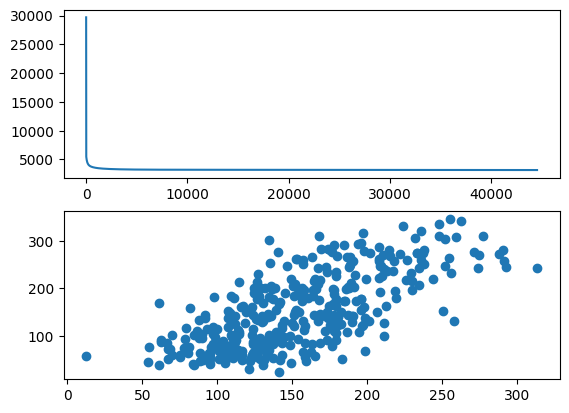


MODEL WEIGHTS
w1	:  0.085602 --> AGE
w2	: -5.011078 --> SEX
w3	:  5.999933 --> BMI
w4	:  0.910511 --> BP
w5	:  1.227340 --> S1
w6	: -1.397610 --> S2
w7	: -2.761243 --> S3
w8	: -1.534979 --> S4
w9	: -0.413076 --> S5
w10	: -0.146421 --> S6
w11	: -0.703927 --> bias

COSTS
Minimum	: 3155.878173828125
Final	: 3155.878173828125


In [14]:
# INITIALISING THE GRADIENT DESCENT PROCESS
# Initializing the model:
model = LinearRegression(x_train.shape[1])
# Obtaining the first set of predictions:
prediction = model.forward(x_train)
# List to store costs generated over descent:
# (starting with the initial cost to begin comparing with)
costList = [mean_squared_error(prediction, y_train)]
# Choosing the learning rate:
alpha = 0.00001
#====================================
# THE GRADIENT DESCENT LOOP
"""
We will run this loop either until 1000000 iterations are up or until we see
an apparent convergence in the cost function values (here, the mean squared
error values) that indicates that we are approaching a minimum cost value.
"""
for i in range(1000000):
  # Doing a gradient descent & getting updated model's predictions:
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
  prediction = model.forward(x_train)
  # Getting & appending updated cost:
  cost = mean_squared_error(prediction, y_train)
  costList.append(cost)
  # Checking for apparent convergence:
  if abs(costList[-1]-costList[-2]) < 0.0000001: break
#====================================
# PLOTTING COSTS OBTAINED IN THE COURSE OF THE GRADIENT DESCENT
fig, ax = plt.subplots(2)
ax[0].plot(list(range(i+2)), costList)
ax[1].scatter(prediction, y_train)
plt.show()
#====================================
# DISPLAYING WEIGHTS & COSTS
# Displaying model weights with the associated column names
weight = [w.item() for w in list(model.weight[0])]
column = list(diabetes_db.columns)[:-1] + ["bias"] # Excluding the Y column
print("\nMODEL WEIGHTS")
for i,w in enumerate(weight):
  sign = {True: "-", False: " "}[w < 0] # For enabling neat display of signs
  print(f"w{i+1}\t: {sign}{abs(w):.6f} --> {column[i]}")

# Displaying minimum cost & final cost:
print("\nCOSTS")
print(f"Minimum\t: {min(costList)}")
print(f"Final\t: {costList[-1]}")

<font color="maroon">**Q5.** What conclusion if any can be drawn from the weight values? How does gender and BMI affect blood sugar levels?

What are the estimated blood sugar levels for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

In [15]:
x1 = torch.tensor([25, 2, 18, 79, 130, 64.8, 61, 2, 4.1897, 68, 1])
x2 = torch.tensor([50, 1, 28, 103, 229, 162.2, 60, 4.5, 6.107, 123, 1])
prediction1 = model.forward(x1)
prediction2 = model.forward(x2)
print("ESTIMATED BLOOD SUGAR LEVELS")
print("Person 1:", prediction1.item())
print("Person 2:", prediction2.item())

ESTIMATED BLOOD SUGAR LEVELS
Person 1: 57.13905715942383
Person 2: 121.59986114501953


Now estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?


In [16]:
prediction_test = model.forward(x_test)
print(mean_squared_error(prediction_test, y_test))

3060.3486328125


<font color="maroon">**Q6.** Try the code with a number of learning rates that differ by orders of magnitude and record the error of the training and test sets. What do you observe on the training error? What about the error on the test set? [3 marks]</font>

In [17]:
# FUNCTION TO PERFORM GRADIENT DESCENT LOOP
def gradient_descent_loop(x, y, alpha, nIterations, getAllCosts=False):
  # NOTE: nIterations ==> Number of loop iterations

  # Initializing the model:
  model = LinearRegression(x.shape[1])
  # The future list of costs obtained:
  costList = []
  #------------------------
  # We will run this loop for `nIterations` iterations
  for i in range(nIterations):
    # Doing gradient descent & getting updated model's predictions:
    prediction = model.forward(x)
    gradient_descent_step(model, x, y, prediction, alpha)
    if getAllCosts: costList.append(mean_squared_error(prediction, y))
  #------------------------
  # Returning obtained mean squared error (cost)
  if getAllCosts: return costList
  return mean_squared_error(prediction, y)

Defining the $\alpha$ values in a list...

In [18]:
alphaList = [0.1**(n) for n in range(1, 9)]

Obtaining all the cost-related data for training and testing data

In [19]:
def getCostData(x, y):
  costs, costsPerLoop = [], []
  for alpha in alphaList:
    costs.append(gradient_descent_loop(x, y, alpha, 100))
    costsPerLoop.append(gradient_descent_loop(x, y, alpha, 100, True))
    # NOTE: costsPerLoop is for plotting purposes later
  return costs, costsPerLoop

train = getCostData(x_train, y_train)
test = getCostData(x_test, y_test)

Displaying the final costs obtained for both training and testing data for the different $\alpha$ values.

In [20]:
pd.DataFrame(
    data = {"cost (in training)": train[0], "cost (in testing)": test[0]},
    index = [f"alpha={alpha:.0e}" for alpha in alphaList])

,cost (in training),cost (in testing)
alpha=1e-01,NaN,NaN
alpha=1e-02,NaN,NaN
alpha=1e-03,NaN,NaN
alpha=1e-04,NaN,NaN
alpha=1e-05,4576.112305,4047.237305
alpha=1e-06,5496.288086,4671.182617
alpha=1e-07,6939.974609,5905.706543
alpha=1e-08,23637.146484,21014.021484


Plotting the cost curves to get a better idea about their convergence or divergence...

In [21]:
def plot_costs(costs, title):
  plt.figure(figsize=(2, 2))
  plt.plot(range(len(costs)), costs)
  plt.title(title)

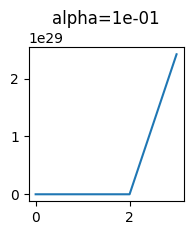

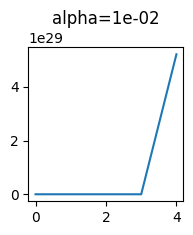

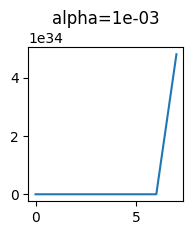

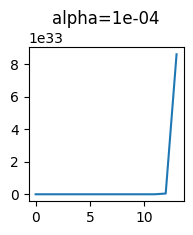

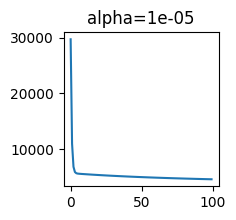

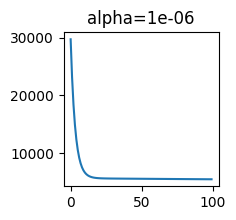

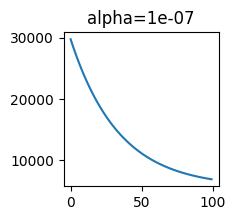

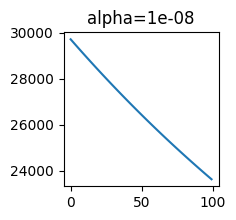

In [22]:
# Plotting cost data for training
for i, alpha in enumerate(alphaList):
  plot_costs(train[1][i], f"alpha={alpha:.0e}")

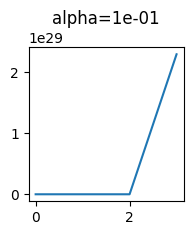

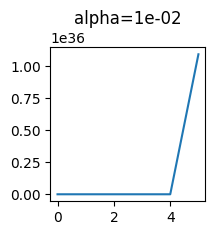

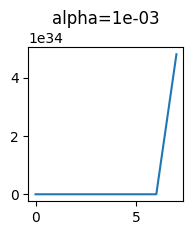

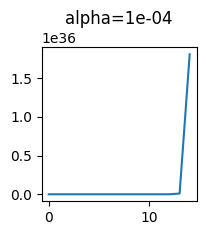

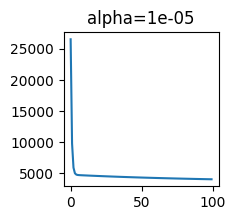

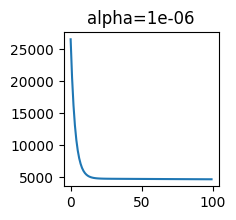

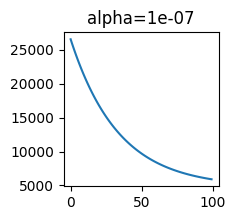

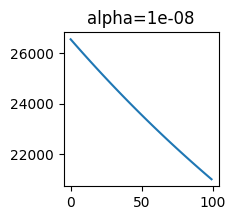

In [23]:
# Plotting cost data for testing
for i, alpha in enumerate(alphaList):
  plot_costs(test[1][i], f"alpha={alpha:.0e}")

# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

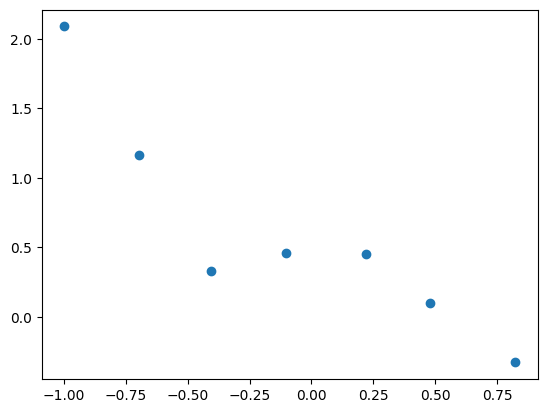

In [24]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right]
$

---

**NOTE**: Here, $m$ is the number of observations (i.e. number of rows in `x`), while $n$ is the number predictors/features (i.e. number of rows in `x`).

---

Adjust variable `x` to include the higher order polynomials

In [25]:
# Adding higher order terms:
x = torch.tensor([list(x**i) for i in range(1, 6)]).T
# We transponse as we want each x^i to be a separate column not a separate row

# Adding bias field:
x = torch.cat([x, torch.ones(x.shape[0], 1)], dim=1)

# Displaying x:
print(x)

tensor([[-9.9768e-01,  9.9537e-01, -9.9306e-01,  9.9075e-01, -9.8845e-01,
          1.0000e+00],
        [-6.9574e-01,  4.8405e-01, -3.3678e-01,  2.3431e-01, -1.6302e-01,
          1.0000e+00],
        [-4.0373e-01,  1.6300e-01, -6.5807e-02,  2.6568e-02, -1.0726e-02,
          1.0000e+00],
        [-1.0236e-01,  1.0478e-02, -1.0725e-03,  1.0978e-04, -1.1237e-05,
          1.0000e+00],
        [ 2.2024e-01,  4.8506e-02,  1.0683e-02,  2.3528e-03,  5.1818e-04,
          1.0000e+00],
        [ 4.7742e-01,  2.2793e-01,  1.0882e-01,  5.1952e-02,  2.4803e-02,
          1.0000e+00],
        [ 8.2229e-01,  6.7616e-01,  5.5600e-01,  4.5719e-01,  3.7595e-01,
          1.0000e+00]])


**Q7.** Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) -
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0
$

In [26]:
# NEW MEAN SQUARED ERROR FUNCTION DEFINITION
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor,
                       lam: float, theta: torch.tensor) -> torch.Tensor:
  m = y_true.shape[0] # Number of observations
  cost = (((y_pred - y_true)**2).sum()/m).item()
  cost += (lam*(theta[0]**2).sum()).item()
  return cost/2*m

In [37]:
# NEW GRADIENT DESCENT STEP FUNCTION DEFINITION
def gradient_descent_step(model: nn.Module, x: torch.Tensor, y: torch.Tensor,
                          y_pred: torch.Tensor, lr: float, lam: float) -> None:
  """
  lr ==> learning rate (chosen constant)
  lam ==> lambda (chosen constant)
  """
  weight = model.weight
  m = x.shape[0] # Number of observations
  NBTW = weight[0][:-1] # Non-bias term weights
  BTW = torch.tensor([weight[0][-1]]) # Bias term weights
  # NOTE: We do not want BTW to have 0 dimensions, so we do the above

  NBTW *= (1-lr*lam/m)
  NBTW -= lr*(x[:, :-1].T * (y_pred - y).T).T.sum(axis=0)/m
  # x[:, :-1] excludes the last column of x, with contains bias
  # NBTW should be a row tensor of n-1 values (n ==> number of columns in x)

  BTW -= lr*(x[:, -1].T * (y_pred - y).T).sum()/m
  # x[:, -1] selects the last column of x, with contains bias
  # BTW should be a single-valued row tensor

  # Mergin NBTW & BTW to get the overall weights
  weight[0] = torch.cat([NBTW, BTW], dim=0)

  # Updating the model
  model.weight = nn.Parameter(weight, requires_grad=False)

In [28]:
# Initializing a new regression model
model = LinearRegression(x.shape[1])
# NOTE: Number of features = Number of columns in x

# Obtaining mean squared error for predicted values
prediction = model.forward(x)
mean_squared_error(y, prediction, 1, model.weight)

3.1786368787288666

<font color="maroon"> **Q8.** First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

In [29]:
# NEW GRADIENT DESCENT LOOP FUNCTION DEFINITION
def gradient_descent_loop(x, y, alpha, lam, nIterations, getAllCosts=False):
  # NOTE: nIterations ==> Number of loop iterations

  # Initializing the model:
  model = LinearRegression(x.shape[1])
  # The future list of costs obtained:
  costList = []
  #------------------------
  # We will run this loop for `nIterations` iterations
  for i in range(nIterations):
    # Doing gradient descent & getting updated model's predictions:
    prediction = model.forward(x)
    gradient_descent_step(model, x, y, prediction, alpha, lam)
    if getAllCosts: costList.append(mean_squared_error(prediction, y, lam, model.weight))
  #------------------------
  # Returning obtained mean squared error (cost)
  if getAllCosts: return costList
  return mean_squared_error(prediction, y, lam, model.weight)

In [44]:
# Finding the alpha which leads to minimum cost
# (we are fixing lambda as 0 for now)
alpha, minCost, minAlpha = 100, 3.18, 0
for i in range(100):
  cost = gradient_descent_loop(x, y, alpha, 0, 100)
  if abs(cost) < minCost:
    minCost, minAlpha = cost, alpha
  alpha /= 10

# Displaying obtained minimum cost & the corresponding alpha
print(f"Cost when alpha={minAlpha}: {minCost}")

Cost when alpha=1.0: 0.05783315282315016


**TECHNICAL NOTE 1**:<br>Given the relatively high number of iterations used for gradient descent, and given the fact that our initial cost (calculated when testing the new mean squared function) is around 3.17, we assume that any $\alpha$ that does not lead to a converging cost will present cost values much larger than 3.17, and will usually have diverged to infinity by the time the last iteration is reached. Thus, any $\alpha$ value leading to lower costs than 3.17 after the end of the iterations is considered to converge.

**TECHNICAL NOTE 2**:<br>If `minAlpha` is less than the maximum value of i (i.e. the upper bound of the for-loop range), then we can conclude that if the cost function converges for $\alpha=\alpha^{minAlpha}$ then it coverges the fastest for `minAlpha`. This because of the following...<br><br>If the cost converges for $\alpha=0.1^{minAlpha}$, then it must converge for all $\alpha=0.1^{minAlpha+k}, k>1$. However, since cost was minimum for `minAlpha`, thus less than the indices that came after it,  it must be that the convergence for all `minAlpha + k` are lesser than it is for `minAlpha`.

---

In [46]:
# Finding the lambda (lam) which leads to minimum cost
# (we are fixing alpha as 1)
lam, minCost, minLam = 0, 3.18, 0
for i in range(100):
  c1 = gradient_descent_loop(x, y, 1, lam, 100)
  c2 = gradient_descent_loop(x, y, 1, -lam, 100)
  if c2 < minCost and c2 > 0 and c2 < c1:
    minCost, minLam = c2, -lam
  elif c1 < minCost:
    minCost, minLam = c1, lam
  lam += 1

# Displaying obtained minimum cost & the corresponding lambda
print(f"Cost when lambda={minLam}: {minCost}")

Cost when lambda=0: 0.05783315282315016


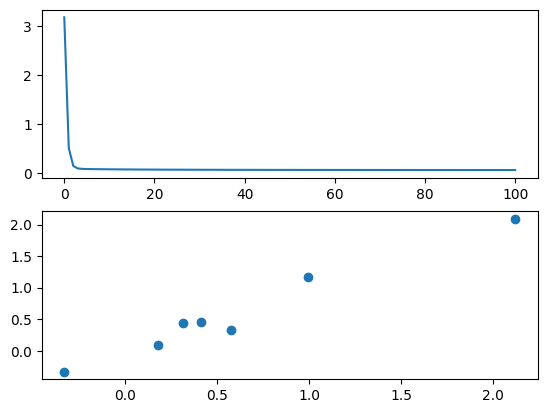


MODEL WEIGHTS
w1	: -0.291935 --> AGE
w2	:  0.090672 --> SEX
w3	: -0.766380 --> BMI
w4	:  0.141654 --> BP
w5	: -0.462333 --> S1
w6	:  0.381659 --> S2

COSTS
Minimum	: 0.0577962277457118
Final	: 0.0577962277457118


In [47]:
# INITIALISING THE NEW GRADIENT DESCENT PROCESS
# Initializing the model:
model = LinearRegression(x.shape[1])
# Obtaining the first set of predictions:
prediction = model.forward(x)
# List to store costs generated over descent:
# (starting with the initial cost to begin comparing with)
costList = [mean_squared_error(prediction, y, lam, model.weight)]
# Choosing the learning rate & lambda:
alpha = 1 # Obtained earlier
lam = 0 # Obtained earlier
#====================================
# THE GRADIENT DESCENT LOOP
"""
We will run this loop either until 1000000 iterations are up or until we see
an apparent convergence in the cost function values (here, the mean squared
error values) that indicates that we are approaching a minimum cost value.
"""
for i in range(100):
  # Doing a gradient descent & getting updated model's predictions:
  gradient_descent_step(model, x, y, prediction, alpha, lam)
  prediction = model.forward(x)
  # Getting & appending updated cost:
  cost = mean_squared_error(prediction, y, lam, model.weight)
  costList.append(cost)
  # Checking for apparent convergence:
  if abs(costList[-1]-costList[-2]) < 0.0000001: break
#====================================
# PLOTTING COSTS OBTAINED IN THE COURSE OF THE GRADIENT DESCENT
fig, ax = plt.subplots(2)
ax[0].plot(list(range(i+2)), costList)
ax[1].scatter(prediction, y)
plt.show()
#====================================
# DISPLAYING WEIGHTS & COSTS
# Displaying model weights with the associated column names
weight = [w.item() for w in list(model.weight[0])]
column = list(diabetes_db.columns)[:-1] + ["bias"] # Excluding the Y column
print("\nMODEL WEIGHTS")
for i,w in enumerate(weight):
  sign = {True: "-", False: " "}[w < 0] # For enabling neat display of signs
  print(f"w{i+1}\t: {sign}{abs(w):.6f} --> {column[i]}")

# Displaying minimum cost & final cost:
print("\nCOSTS")
print(f"Minimum\t: {min(costList)}")
print(f"Final\t: {costList[-1]}")

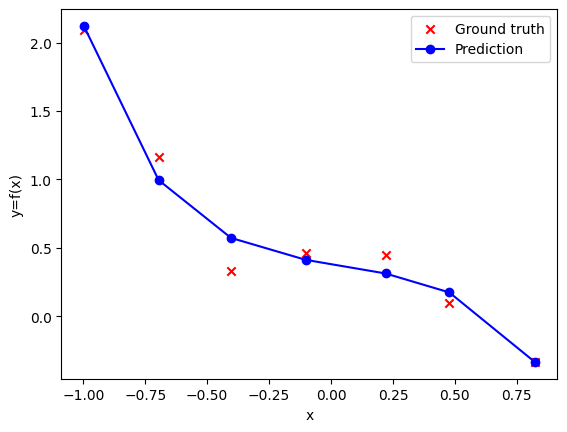

In [48]:
plt.scatter(x[:, 0], y, c='red', marker='x', label='Ground truth')
# NOTE: x[:, 0] gives the 1st column, which consists of the original x values
prediction = model.forward(x)
plt.plot(x[:, 0], prediction, c='blue', marker='o', label='Prediction')
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.legend()
plt.show()